# In this notebook I will:
* Go through and remove reviews that only have advertisements?
* Process reviews into positive and negative fractions
* One hot encode medication information
* CLEANING SIDE EFFECTS FILE BY HAND (combining, removing duplicates, ignoring syntax)
* BOW side effects, BOW reviews and compare somehow?
* Save files with processed reviews to SA_vader directory

In [13]:
import pandas as pd
import numpy as np
import glob

# Haven't decided whether I like nltk or spacy better yet
import nltk
from nltk import sentiment
VADER_SIA = sentiment.vader.SentimentIntensityAnalyzer()
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.corpus import wordnet, stopwords
# stops = stopwords.words('english')
# import spacy
# import en_core_web_lg
# nlp = en_core_web_lg.load()

# A method to process text in nltk:
# https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

# same process in spacy
# https://spacy.io/usage/linguistic-features

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Just don't have time to learn these right now
#from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from scipy.spatial import distance
cdist = distance.cdist

In [80]:
# Adjusting stop words in spacy to not lose a bunch of negatives for the sentiment analysis
for word in [u'nor',u'none',u'not',u'alone',u'no',u'never',u'cannot',u'always']:
    nlp.vocab[word].is_stop = False

# Working with the unique medications files to identify which processed reviews to work with


In [76]:
# Find all the conditions and their unique medications to work with
ConditionFiles = glob.glob('UniqueMedications/*csv')
conditions = [file[file.rfind('_')+1:file.rfind('.')] for file in ConditionFiles]
condMeds = {}
for cond, file in zip(conditions, ConditionFiles):
    DF = pd.read_csv(file, sep='$', usecols=[1])
    condMeds[cond] = [med.strip() for med in list(DF['Medication'])]
    
# Locate all the medication files for each condition
condMedFiles = {}
for cond in conditions:
    files = glob.glob('ProcessedReviews/{:s}/*parsed_reviews.csv'.format(cond))
    condMedFiles[cond] = []
    remove = []
    for med in condMeds[cond]:
        newfiles = [file for file in files if file.find(med) != -1]
        if not newfiles:
            remove.append(med)
        else:
            condMedFiles[cond] += newfiles
    for med in remove:
        condMeds[cond].remove(med)

In [77]:
# For each medication file, create a dataframe with:
#   1. columns for each medication and 1/0 for the medication present
#   2. column for holding the positive or negative vader values
#   3. average weight to be used on each review
#     --> Computed as the euclidean distance of every pos (x) /neg (y) from the other
#   4. add in info on side effect mentions

# Creating a dataframe with columns for every medication and 1/0 for present
def generateMedDF(medication, revFile, meds4Cond):
    # Reading in the reviews file
    reviews = pd.read_csv(revFile, sep='$', index_col=0)
    
    # Poor man's one hot encode
    baseDataDict = {}
    for med in meds4Cond: baseDataDict[med] = 0
    baseDataDict[medication] = 1
    baseDataDict['weight'] = 0    # placeholder
    
    # Adding in the positive and negative reviews
    list4DF = []
    for ind in reviews.index:
        # Copying over the repeated aspects
        dataDict = baseDataDict.copy()

        # Adding in reviewer information to avoid having to do it later
        # Removing username because some people included way too personal info
        for key in ['Age', 'Gender', 'Length of treatment']:
            dataDict[key] = reviews.loc[ind][key]
        
        # Evaluating the comment
        comment = reviews.loc[ind]['Comment']
        polarity = VADER_SIA.polarity_scores(comment)
        dataDict['Postive polarity fraction'] = polarity['pos'] 
        dataDict['Negative polarity fraction'] = polarity['neg'] 

        # Appending to a list to make the dataframe with
        list4DF.append(dataDict)
        
    # Creating the dataframe
    medDF = pd.DataFrame(list4DF, index=reviews.index)
        
    # Generating the weight for the reviews based on euclidean distance (cdist default)
    x = np.vstack((medDF['Postive polarity fraction'], 
                   medDF['Negative polarity fraction'])).T
    dists = cdist(x,x)
    weight = dists.mean()   # Will then be adjusted in giant table to be
                            # w = max(all weights) / weight
    medDF['weight'] = [weight]*len(medDF) # Doesn't need to be normalized because all are fractions of reviews    
    
    # Reseting index to avoid stacking issues
    medDF = medDF.reset_index().drop(columns=['index'])
    
    return medDF

In [87]:
# Concatenate dataframes into one giant dataframe for condition
for condition in ['Depression']:
    medications = condMeds[condition]
    for i, med in enumerate(medications):
        if i == 0:
            medDF = generateMedDF(med, condMedFiles[condition][i], medications)
        else:
            newMedDF = generateMedDF(med, condMedFiles[condition][i], medications)
            medDF = medDF.append(newMedDF, ignore_index=True, sort=False)
    
    # Normalizing weights
    medDF['weight'] = medDF['weight'] / medDF['weight'].max()
    
    # Saving stacked dataframelambda u, v: np.sqrt(((u-v)**2).sum())

array([0.66158897, 0.81274911, 0.84405867, 0.87341243, 0.89563065,
       0.90127482, 0.90971226, 0.9184514 , 0.93693239, 0.94125209,
       0.97234453, 1.        ])

In [10]:
condMeds['ADHD'], condMedFiles['ADHD']

(['Amphetamine',
  'Nortriptyline',
  'Desipramine',
  'Imipramine',
  'Focalin',
  'Adderall',
  'Evekeo',
  'Tenex',
  'Catapres',
  'WellbutrinXL'],
 ['ProcessedReviews/ADHD/Amphetamine_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Nortriptyline_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Desipramine_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Imipramine_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Focalin_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Adderall_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Evekeo_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Tenex_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/Catapres_ADHD_parsed_reviews.csv',
  'ProcessedReviews/ADHD/WellbutrinXL_ADHD_parsed_reviews.csv'])

In [144]:
# Grabbing original medications/SE dataframe to identify what words are important to keep
def makeListofStr(s: str) -> list:
    List = s[1:-1].split("'")
    List = [string for string in List if string and string != ', ']
    return List

medsDF = pd.read_csv('Medications_SideEffects_brandAndlinks.csv', index_col=0,
                    converters={'Parent links': lambda x: makeListofStr(x), 'Exact medications': lambda x: makeListofStr(x)})

# Processing the reviews files

In [25]:
# A function to parse the reviewer information
def parse_reviewer(reviewer):
    # Find name as unique identifier if present
    if reviewer.find(',') != -1:
        name = reviewer[reviewer.find(':')+2:reviewer.find(',')]
    else:
        name = np.NaN
    
    # Find age range as datapoint if present
    if reviewer.find('-') != -1:
        if reviewer.find(',') != -1:
            age = reviewer[reviewer.find(',')+2:reviewer.find(' ', reviewer.find('-'))]
        else:
            age = reviewer[reviewer.find(':')+2:reviewer.find(' ', reviewer.find('-'))]
    else:
        age = np.NaN
        
    # Find gender if present
    if reviewer.find('Male') != -1:
        gender = 'Male'
    elif reviewer.find('Female') != -1:
        gender = 'Female'
    else:
        gender = np.NaN
        
    # Find treatment time
    if reviewer.find('on Treatment') != -1:
        if reviewer.rstrip()[-1] == ')':
            treatment_time = reviewer[reviewer.find('on Treatment for ')+16:reviewer.rfind('(')].strip()
        else:
            treatment_time = reviewer[reviewer.find('on Treatment for ')+16:].rstrip().strip()
    else:
        treatment_time = np.NaN
    
    # Put info in a dictionary that can be made into a dictionary
    reviewer_info = {}
    reviewer_info['Name'] = name
    reviewer_info['Age'] = age
    reviewer_info['Gender'] = gender
    reviewer_info['Length of treatment'] = treatment_time
    
    return reviewer_info

def processReviewerColumn(reviewDF):
    # Parse the reviewer info
    reviewers = []
    for reviewer in reviewDF['reviewer']:
        reviewers.append(parse_reviewer(reviewer))
    reviewersDF = pd.DataFrame(reviewers, index=reviewDF.index)

    # Drop the reviewer column from the original dataframe
    reviewDF = reviewDF.drop(columns=['reviewer'])

    # Add the parsed reviewer info to the original dataframe
    reviewDF = pd.concat([reviewDF, reviewersDF], axis=1)
    
    return reviewDF

In [19]:
# Grabbing all the files I need to process
files = glob.glob('ProcessedReviews/*raw_reviews.csv')
files = [file for file in files if file.find('allconditions') == -1]

In [20]:
# Playing around with a single file to start
file0 = files[0]
df = pd.read_csv(file0, sep='$', index_col=0)
parsedDF = processReviewerColumn(df).dropna(subset=['Comment'])

In [84]:
comments = [(ind,parsedDF.loc[ind]['Comment']) for ind in parsedDF.index]

In [140]:
# Working on sentiment analysis
# Starting source: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python
# Other source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

def comment_features(comment):
    document = list(nltk.FreqDist(w for w in spacyTokenizer(comment)))
    document_words = set(document)
    
    features = {}
    for word in document:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def dichotomize_satisfaction(score):
    if score > 3:
        return 'positive'
    else:
        return 'negative'

featuresets = [(comment_features(comment),dichotomize_satisfaction(sat)) for comment, sat in zip(parsedDF['Comment'], parsedDF['Effectiveness'])] 
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier.show_most_informative_features(20)

Most Informative Features
      contains(research) = True           negati : positi =      8.0 : 1.0
          contains(blur) = True           negati : positi =      7.7 : 1.0
     contains(nauseated) = True           negati : positi =      7.7 : 1.0
         contains(shake) = True           negati : positi =      7.7 : 1.0
      contains(severely) = True           negati : positi =      7.7 : 1.0
          contains(okay) = True           negati : positi =      6.3 : 1.0
         contains(worse) = True           negati : positi =      6.3 : 1.0
          contains(zero) = True           negati : positi =      6.3 : 1.0
     contains(beginning) = True           negati : positi =      6.3 : 1.0
        contains(remove) = True           negati : positi =      6.3 : 1.0
         contains(happy) = True           positi : negati =      5.1 : 1.0
       contains(violent) = True           negati : positi =      4.9 : 1.0
   contains(alternative) = True           negati : positi =      4.9 : 1.0

In [134]:
featuresets

[({'contains(low)': True,
   'contains(dose)': True,
   'contains(venlafaxine)': True,
   'contains(year)': True,
   'contains(feel)': True,
   'contains(great)': True,
   'contains(rarely)': True,
   'contains(suffer)': True,
   'contains(anxiety)': True,
   'contains(like)': True,
   'contains(past)': True},
  'positive'),
 ({'contains(dose)': True,
   'contains(range)': True,
   'contains(day)': True,
   'contains(find)': True,
   'contains(emotion)': True,
   'contains(narrow)': True,
   'contains(unfortunately)': True,
   'contains(dull)': True,
   'contains(high)': True,
   'contains(cause)': True,
   'contains(ed)': True,
   'contains(crazy)': True,
   'contains(dream)': True,
   'contains(difficult)': True,
   'contains(no)': True,
   'contains(longer)': True,
   'contains(take)': True},
  'negative'),
 ({'contains(help)': True,
   'contains(depression)': True,
   'contains(anxiety)': True,
   'contains(cost)': True,
   'contains(overwhelming)': True,
   'contains(nausea)': Tru

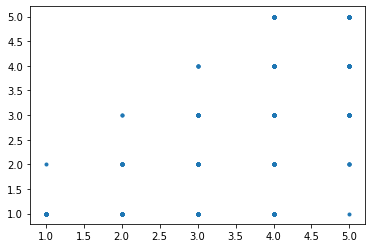

In [105]:
# Can effectiveness be a feature?
plt.scatter(parsedDF['Effectiveness'], parsedDF['Satisfaction'], marker='.')

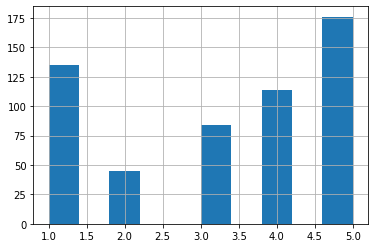

In [161]:
parsedDF['Satisfaction'].hist()

In [208]:
VADER_SIA = nltk.sentiment.vader.SentimentIntensityAnalyzer()

VADERscore = []
for comment in parsedDF['Comment']:
    VADERscore.append(VADER_SIA.polarity_scores(comment)['compound'])    

I have been on a low dose of venlafaxine for several years now, and feel great.  Rarely do I suffer from any anxiety or feel down like I did in the past. 0.7684
I have been on various doses ranging from 37.5 to 150 per day. I found it made my range of emotions much narrower, but unfortunately it dulled the highs ... I found the higher dose was causing ED and some crazy dreams. Difficult to get off of. I am no longer taking it. -0.899
It has helped my depression and anxiety, but at a cost. I have overwhelming nausea, dizziness, and headaches at least 2 days a week. I love what the drug has done for my mental health but my physical health, not so much. 0.6249
I have been on effexor first at 75 mg now at 115 mg for over 15 years.  I dont feel any different as a person but have less if no anxiety or depression.  I have not had any of the side effects plus i drink white wine daily.  My sleep has been very good but you do have very vivid interesting dreams.  This drug changed and saved my li

I had been taking this medication for many years, about 8. I would occasionaly suffer breakthrough depression. A new doctor suggested changing to something new. Nothing has worked as well and I have tried many meds in the last 6 months! I am considering going back and trying and adjunct med for the occasional depresion. -0.75
WHAT I LIKED THE MOST WAS THE SHORT PERIOD OF TIME REQUIRED FOR THE MEDICATION TO PROVIDE RELIEF ABOUT 7 DAYS 0.7096
Overall I am less anxious, however I now suffer from pounding headaches that may result to me getting off medication. -0.6378
After some initial benefits from this drug, the side effects became to much to bear.  I had several with the most irritating being constipation and unable to ejaculate.  Withdrawal is terrible, just completed a 59 day withdrawal program and still had withdrawal problems for a week. All the side effects have now disappeared and I am taking 5 htp for anixety which is working very well.  Stay away from effeor or venaflaxine. -0.

[0.7684,
 -0.899,
 0.6249,
 0.8323,
 -0.5222,
 -0.9388,
 -0.9553,
 0.7242,
 0.7069,
 -0.9521,
 -0.4019,
 0.591,
 0.9427,
 0.9755,
 -0.8187,
 -0.9323,
 -0.8439,
 0.9607,
 -0.2878,
 0.0,
 -0.5052,
 -0.9277,
 -0.7738,
 -0.9268,
 -0.7923,
 -0.9798,
 -0.9062,
 0.7565,
 -0.8877,
 -0.1045,
 -0.4015,
 0.6109,
 -0.8847,
 -0.8402,
 -0.5432,
 0.25,
 0.1477,
 -0.925,
 -0.6705,
 0.9383,
 -0.6465,
 0.9155,
 -0.8466,
 -0.5423,
 -0.5423,
 -0.7614,
 -0.9055,
 0.1531,
 0.0,
 -0.8399,
 -0.4404,
 0.0,
 -0.7535,
 0.8132,
 0.4023,
 -0.2732,
 -0.9501,
 -0.7966,
 -0.8729,
 0.7609,
 -0.3876,
 0.0,
 0.401,
 -0.9719,
 -0.802,
 0.4404,
 0.9313,
 0.296,
 -0.4004,
 -0.9637,
 -0.5994,
 -0.1985,
 -0.9516,
 0.3506,
 0.0,
 0.6115,
 -0.9237,
 0.0,
 0.222,
 -0.921,
 -0.7016,
 -0.5267,
 0.5365,
 -0.8176,
 -0.7574,
 0.8321,
 -0.7249,
 0.6369,
 0.0,
 -0.8286,
 -0.2292,
 0.8698,
 -0.7964,
 -0.693,
 -0.863,
 0.7193,
 -0.8601,
 -0.7663,
 0.6476,
 -0.9396,
 0.8896,
 0.6261,
 -0.9582,
 0.3858,
 0.0601,
 -0.8958,
 0.0695,
 -0.901

In [226]:
parsedDF = parsedDF.reset_index().drop(columns=['index'])
VADER_Sat_box = [np.array([VADERscore[j] for j in parsedDF[parsedDF['Satisfaction'].eq(i)].index]) for i in range(1,6)]
VADER_Eff_box = [np.array([VADERscore[j] for j in parsedDF[parsedDF['Effectiveness'].eq(i)].index]) for i in range(1,6)]


In [223]:
VADERscore_box[2]

array([-0.899 ,  0.6249, -0.8877,  0.9155,  0.    , -0.2732,  0.401 ,
       -0.9719, -0.802 ,  0.8698, -0.863 , -0.8601,  0.3858,  0.0601,
        0.    , -0.5998, -0.926 , -0.4333, -0.3979, -0.8271,  0.8917,
       -0.913 , -0.3484,  0.7963, -0.5716, -0.3204,  0.3182, -0.3612,
        0.8462, -0.7876,  0.6292, -0.5719, -0.6124, -0.7123,  0.6514,
        0.6405,  0.5856,  0.2924, -0.8818, -0.9073,  0.9007,  0.3612,
       -0.5423, -0.75  , -0.6378,  0.6464,  0.379 ,  0.6083,  0.394 ,
       -0.6308, -0.9239, -0.4404,  0.2307,  0.9488,  0.9845, -0.296 ,
       -0.128 , -0.8567,  0.7453,  0.6187,  0.7771, -0.6486,  0.8389,
       -0.743 ,  0.2363, -0.1796, -0.5106,  0.9538, -0.9317,  0.9596,
       -0.7251,  0.9528, -0.8998, -0.9635, -0.3612, -0.705 , -0.955 ,
        0.2382, -0.2212,  0.6838, -0.8126,  0.2382,  0.1613,  0.705 ])

Text(0.5, 1.0, 'Effectiveness')

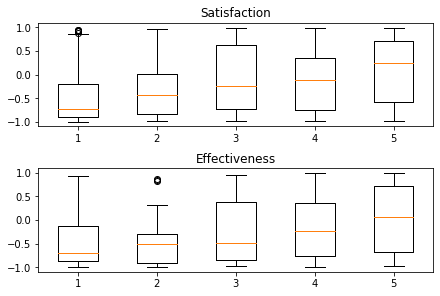

In [228]:
fig, ax = plt.subplots(2, constrained_layout=True)
ax[0].boxplot(x=VADER_Sat_box)
ax[1].boxplot(x=VADER_Eff_box)
ax[0].set_title('Satisfaction')
ax[1].set_title('Effectiveness')